# **Biểu đồ về missing**

In [146]:
import pandas as pd
import numpy as np
import os
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from scipy.optimize import minimize
from IPython.display import clear_output
from colorama import Fore, Style

# Load CSV files from local Data/raw directory
train = pd.read_csv('/Users/user/Desktop/Project_DataPreVisual_Group_1/Data/raw/train.csv')
test = pd.read_csv('/Users/user/Desktop/Project_DataPreVisual_Group_1/Data/raw/test.csv')
sample = pd.read_csv('/Users/user/Desktop/Project_DataPreVisual_Group_1/Data/raw/sample_submission.csv')

def process_file(filename, dirname):
    # Đọc tệp Parquet
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    
    # Tính toán các thống kê mô tả
    desc_df = df.describe().T # .T để chuyển vị, đưa các cột thành chỉ mục và các thống kê thành cột
    
    # Tạo tên cột mới bằng cách kết hợp Tên cột gốc và Tên thống kê (ví dụ: 'Age_mean')
    # Các thống kê mặc định: ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
    new_cols = []
    values = []
    
    # Duyệt qua từng hàng (là từng cột gốc) của DataFrame thống kê
    for col in desc_df.index:
        for stat in desc_df.columns:
            # Tạo tên mới: {Tên_cột_gốc}_{Tên_thống_kê}
            new_name = f"{col}_{stat}"
            new_cols.append(new_name)
            
            # Lấy giá trị thống kê tương ứng
            values.append(desc_df.loc[col, stat])
            
    # Trả về các giá trị thống kê (dạng mảng 1D) và danh sách tên cột
    # Đồng thời trả về ID
    return values, new_cols, filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        # Sử dụng map như trước, kết quả sẽ là list các tuples: (values, new_cols, index)
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    # Tách kết quả thành 3 lists riêng biệt
    stats_values, col_names_list, indexes = zip(*results)
    
    # Lấy danh sách tên cột từ mẫu đầu tiên (giả định tất cả các tệp có cùng cấu trúc cột)
    if col_names_list:
        new_columns = col_names_list[0]
    else:
        # Xử lý trường hợp không có tệp nào
        return pd.DataFrame()
        
    # Tạo DataFrame mới sử dụng các giá trị thống kê và tên cột đã tạo
    df = pd.DataFrame(list(stats_values), columns=new_columns)
    df['id'] = indexes
    return df

In [147]:
# ============================
# CHECK COLUMN COUNTS
# ============================

print("----- RAW CSV FILES -----")
print(f"Train CSV columns     : {len(train.columns)}")
print(f"Test CSV columns      : {len(test.columns)}")
print(f"Sample Submission cols: {len(sample.columns)}")






----- RAW CSV FILES -----
Train CSV columns     : 82
Test CSV columns      : 59
Sample Submission cols: 2


### **Kiểm tra tổng số giá trị missing theo từng cột**

In [148]:
missing_count = train.isna().sum()
print(missing_count)

id                                           0
Basic_Demos-Enroll_Season                    0
Basic_Demos-Age                              0
Basic_Demos-Sex                              0
CGAS-Season                               1405
                                          ... 
SDS-SDS_Total_Raw                         1351
SDS-SDS_Total_T                           1354
PreInt_EduHx-Season                        420
PreInt_EduHx-computerinternet_hoursday     659
sii                                       1224
Length: 82, dtype: int64


### **Chỉ hiển thị những cột có missing (lọc bỏ cột không có NA)**

In [149]:
missing_only = train.isna().sum()
missing_only = missing_only[missing_only > 0]

print("Các cột có missing values:")
print(missing_only)


Các cột có missing values:
CGAS-Season                               1405
CGAS-CGAS_Score                           1539
Physical-Season                            650
Physical-BMI                               938
Physical-Height                            933
                                          ... 
SDS-SDS_Total_Raw                         1351
SDS-SDS_Total_T                           1354
PreInt_EduHx-Season                        420
PreInt_EduHx-computerinternet_hoursday     659
sii                                       1224
Length: 78, dtype: int64


### **Hiển thị tỷ lệ % missing theo từng cột**

In [150]:
missing_percent = train.isna().mean() * 100

print("Tỷ lệ % missing theo từng cột:")
print(missing_percent)


Tỷ lệ % missing theo từng cột:
id                                         0.000000
Basic_Demos-Enroll_Season                  0.000000
Basic_Demos-Age                            0.000000
Basic_Demos-Sex                            0.000000
CGAS-Season                               35.479798
                                            ...    
SDS-SDS_Total_Raw                         34.116162
SDS-SDS_Total_T                           34.191919
PreInt_EduHx-Season                       10.606061
PreInt_EduHx-computerinternet_hoursday    16.641414
sii                                       30.909091
Length: 82, dtype: float64


### **Tổng số cột có missing**

In [151]:
num_missing_cols = train.isna().any().sum()

print("Tổng số cột có missing:", num_missing_cols)

Tổng số cột có missing: 78


### **Danh sách các cột có missing**

In [152]:
missing_columns = train.columns[train.isna().any()].tolist()

print("Danh sách cột có missing:")
print(missing_columns)


Danh sách cột có missing:
['CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season', 'PAQ_C-PAQ_C_Total', 'PCIAT-Season', 'PCIAT-PCIAT_01', 'PCI

# **1.Biểu đồ thể hiện top cột bị missing nhiều nhất**

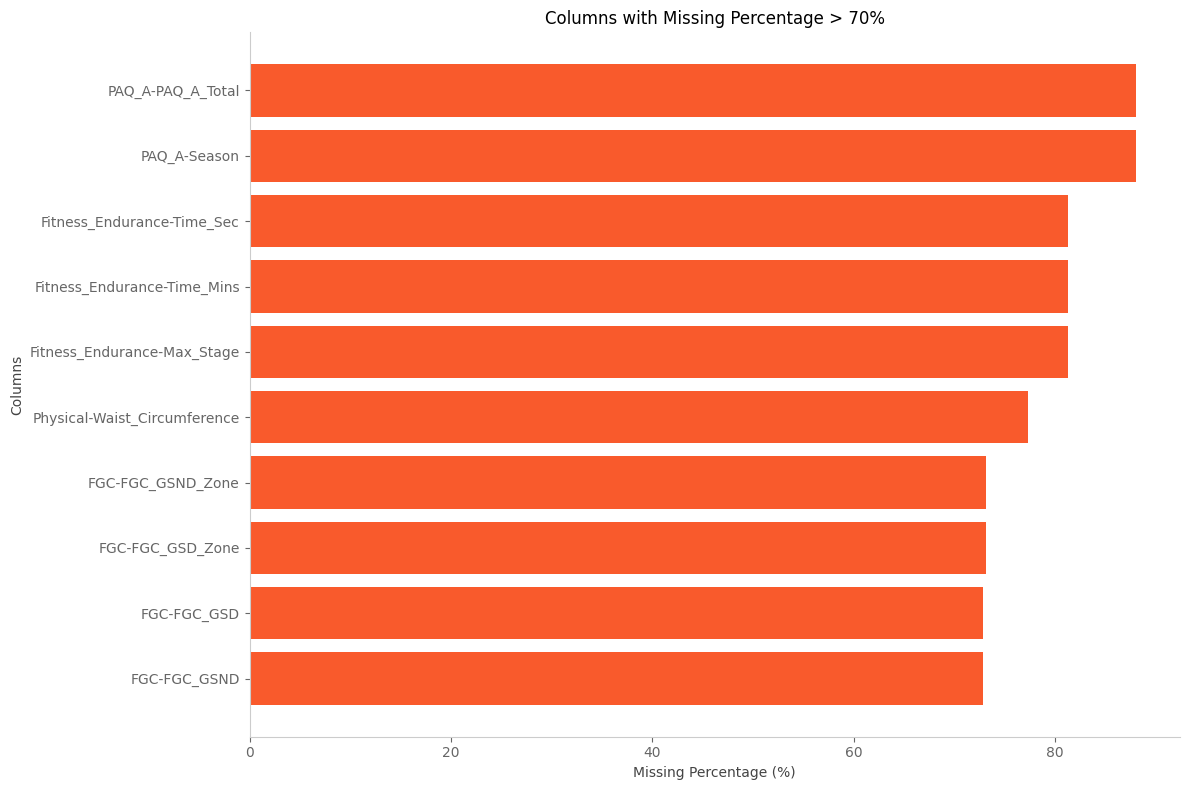

In [153]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Tính tỷ lệ missing
missing_percent = train.isna().mean() * 100

# 2. Lọc các cột có missing > 70%
missing_over_70 = missing_percent[missing_percent > 70].sort_values()

# Kiểm tra nếu không có cột nào > 70%
if missing_over_70.empty:
    print("Không có cột nào có missing > 70%")
else:
    # 3. Vẽ bar chart
    plt.figure(figsize=(12, 8))

    # VẼ BAR MÀU CAM
    plt.barh(
        missing_over_70.index,
        missing_over_70.values,
        color="#F95A2C"
    )

    ax = plt.gca()

    # ---- đổi màu trục x y ----
    ax.spines["bottom"].set_color("#CCCCCC")
    ax.spines["left"].set_color("#CCCCCC")

    # ---- bỏ 2 viền khung bên ngoài ----
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # ---- chỉnh màu ticks + labels ----
    ax.tick_params(colors="#666666")
    ax.yaxis.label.set_color("#444444")
    ax.xaxis.label.set_color("#444444")

    # ---- bỏ grid ----
    ax.grid(False)

    # ---- TIÊU ĐỀ MÀU ĐEN ----
    plt.title("Columns with Missing Percentage > 70%", color="black")

    plt.xlabel("Missing Percentage (%)")
    plt.ylabel("Columns")

    plt.tight_layout()
    plt.show()


# **2.Biểu đồ thể hiện số cột bị missing theo từng nhóm tỷ lệ**

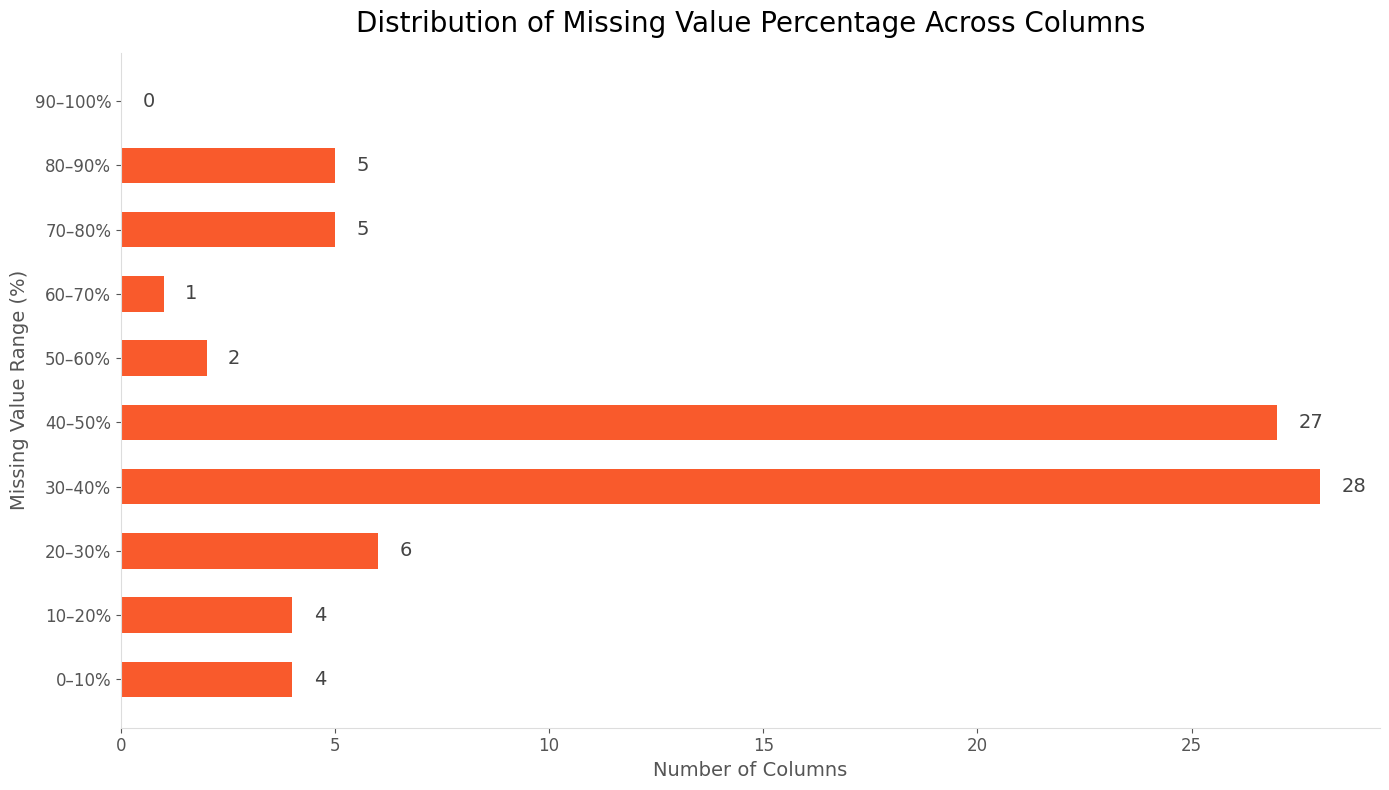

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 0. Đọc dữ liệu gốc
df = pd.read_csv("/Users/user/Desktop/Project_DataPreVisual_Group_1/Data/raw/train.csv")   

# 1. Tỷ lệ missing (%)
missing_ratio = df.isna().mean() * 100  

# 2. Bins
bins = np.arange(0, 110, 10)
labels = [f"{bins[i]}–{bins[i+1]}%" for i in range(len(bins)-1)]

# 3. Phân nhóm
groups = pd.cut(missing_ratio, bins=bins, labels=labels, right=False)

# 4. Đếm số cột theo nhóm
count_by_group = groups.value_counts().sort_index()

# 5. Màu thanh (cam)
colors = ['#F95A2C'] * len(count_by_group)

plt.figure(figsize=(14, 8))
ax = plt.gca()

bars = ax.barh(count_by_group.index, count_by_group.values,
               color=colors, height=0.55)

# 6. Text số bên phải thanh bar
for i, v in enumerate(count_by_group.values):
    ax.text(v + 0.5, i, str(v), va='center', fontsize=14, color='#444')

# Titles và labels
ax.set_title("Distribution of Missing Value Percentage Across Columns",
             fontsize=20, pad=15, color="black")
ax.set_xlabel("Number of Columns", fontsize=14, color="#555555")
ax.set_ylabel("Missing Value Range (%)", fontsize=14, color="#555555")

# ❌ Bỏ grid
ax.grid(False)

# ✔ Giữ lại trục X/Y và đổi sang màu xám nhạt
light_gray = "#DDDDDD"
ax.spines['bottom'].set_color(light_gray)
ax.spines['left'].set_color(light_gray)

# Ẩn viền không cần thiết
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Tick màu #555555
ax.tick_params(axis='x', colors='#555555', labelsize=12)
ax.tick_params(axis='y', colors='#555555', labelsize=12)

plt.tight_layout()
plt.show()


# **3. Text thể hiện số cột bị missing**

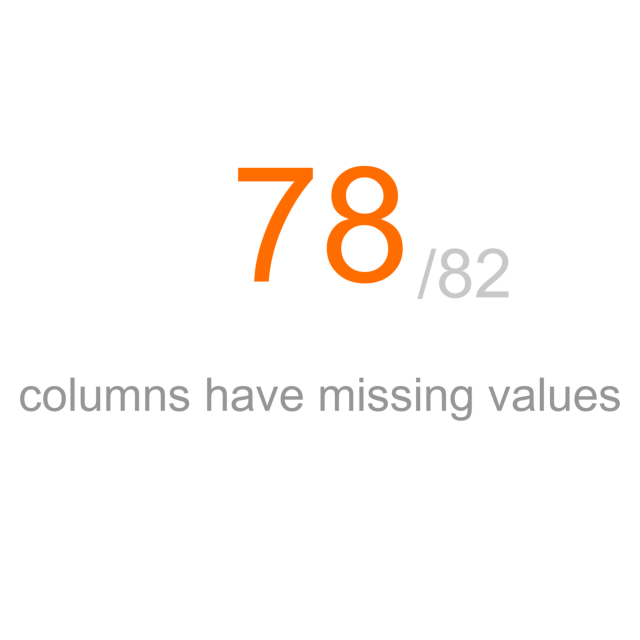

In [163]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import os

def auto_font(size):
    search_dirs = [
        "/usr/share/fonts",
        "/usr/local/share/fonts",
        os.path.expanduser("~/.fonts"),
        "C:/Windows/Fonts",
        "/Library/Fonts"
    ]
    for folder in search_dirs:
        if os.path.exists(folder):
            for root, dirs, files in os.walk(folder):
                for f in files:
                    if f.lower().endswith(".ttf"):
                        try:
                            return ImageFont.truetype(os.path.join(root, f), size)
                        except:
                            pass
    return ImageFont.load_default()


# ==========================
# 📌 TEXT SETUP
# ==========================
big_text = "78"
small_text = "/82"
label_text = "columns have missing values"

pad = 200
W, H = 1600 + pad*2, 1600 + pad*2

font_big = auto_font(520)
font_small = auto_font(220)
font_label = auto_font(150)

tmp = Image.new("RGB", (W, H), "white")
d = ImageDraw.Draw(tmp)

bw, bh = d.textbbox((0, 0), big_text, font=font_big)[2:]
sw, sh = d.textbbox((0, 0), small_text, font=font_small)[2:]
lw, lh = d.textbbox((0, 0), label_text, font=font_label)[2:]

x_big = (W - bw) // 2
y_big = pad + 120
x_small = x_big + bw + 25
y_small = y_big + bh - sh + 50
x_label = (W - lw) // 2
y_label = y_small + sh + 200

img = Image.new("RGB", (W, H), "white")
draw = ImageDraw.Draw(img)

# ==========================
ORANGE_BOLD = (255, 109, 0)          # màu cam đậm cho "78"
GRAY_VERY_LIGHT = (200, 200, 200)     # màu xám rất nhạt cho "/82"
GRAY_MEDIUM = (150, 150, 150)         # màu xám đậm hơn cho label_text

# Draw text
draw.text((x_big, y_big), big_text, font=font_big, fill=ORANGE_BOLD)
draw.text((x_small, y_small), small_text, font=font_small, fill=GRAY_VERY_LIGHT)
draw.text((x_label, y_label), label_text, font=font_label, fill=GRAY_MEDIUM)
# 📌 SHOW IMAGE
# ==========================
plt.figure(figsize=(8, 9))
plt.imshow(img)
plt.axis("off")
plt.show()


# **4. Biểu đồ thể hiện tổng số cột bị missing theo 3 loại missing**

# **Import & Load Data**

In [164]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import chi2

# Load data
df = pd.read_csv("/Users/user/Desktop/Project_DataPreVisual_Group_1/Data/raw/train.csv")


## **a. MCAR — Little’s Test (Hàm sạch & ổn định)**

In [165]:
def little_mcar_test(df):
    df_numeric = df.select_dtypes(include=[np.number]).astype(float).copy()

    # Bỏ hàng toàn missing
    df_numeric = df_numeric.dropna(how="all")

    # Tính mean từng cột
    mean_vec = np.nanmean(df_numeric.values, axis=0)

    # (x - mean)^2 và bỏ NaN bằng 0
    diff = df_numeric.values - mean_vec
    diff_sq = np.nan_to_num(diff ** 2)

    # Chi-square statistic
    stat = np.sum(diff_sq)

    # Degrees of freedom = số cột numeric
    dfree = df_numeric.shape[1]

    # p-value
    p_value = 1 - chi2.cdf(stat, dfree)

    return stat, p_value


# ---- RUN MCAR TEST ----
stat, p_mcar = little_mcar_test(df)

print("Little’s MCAR test statistic:", stat)
print("MCAR p-value:", p_mcar)

if p_mcar > 0.05:
    print("⇒ Missing có khả năng là MCAR")
else:
    print("⇒ Missing KHÔNG phải MCAR (có thể là MAR hoặc MNAR)")


Little’s MCAR test statistic: 23270519385.828213
MCAR p-value: 0.0
⇒ Missing KHÔNG phải MCAR (có thể là MAR hoặc MNAR)


## **b. MAR — Logistic Regression (phiên bản ổn định nhất)**

In [166]:
mar_columns = []

for col in df.columns:

    # Nếu cột không có missing → bỏ
    if df[col].isna().sum() == 0:
        continue

    # Tạo biến chỉ báo missing
    miss_flag = df[col].isna().astype(int)

    # Chọn predictor numeric KHÔNG có missing
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c != col and df[c].isna().sum() == 0]

    # Cần ≥ 2 biến numeric không missing mới chạy được
    if len(numeric_cols) < 2:
        continue

    X = sm.add_constant(df[numeric_cols])
    y = miss_flag

    try:
        model = sm.Logit(y, X, missing="drop").fit(disp=False)
        p_mean = model.pvalues.mean()

        # Nếu missing phụ thuộc predictor → MAR
        if p_mean < 0.05:
            mar_columns.append(col)

    except:
        continue

print("\nCác cột có missing dạng MAR:", mar_columns)
print("Số lượng MAR:", len(mar_columns))



Các cột có missing dạng MAR: ['CGAS-Season', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'PCIAT-PCIAT_09', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday']
Số lượng MAR: 23


## **c. MNAR — Còn lại ≠ MCAR và ≠ MAR**

In [167]:
mnar_columns = []

for col in df.columns:
    if df[col].isna().sum() == 0:
        continue

    # Nếu không thuộc MAR → nghi MNAR
    if col not in mar_columns:
        mnar_columns.append(col)

print("\nCác cột nghi MNAR:", mnar_columns)
print("Số lượng MNAR:", len(mnar_columns))



Các cột nghi MNAR: ['Physical-Season', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season', 'PAQ_C-PAQ_C_Total', 'PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'SDS-Sea

In [168]:
# --------------------------------------------
# ĐẾM SỐ CỘT THUỘC TỪNG LOẠI MISSING
# --------------------------------------------

total_columns = df.shape[1]

# MCAR chỉ xảy ra khi toàn dataset đạt MCAR
if p_mcar > 0.05:
    mcar_columns = list(df.columns)    # all numeric columns được xem MCAR
else:
    mcar_columns = []                  # không có cột nào MCAR nếu test thất bại

num_mcar = len(mcar_columns)
num_mar = len(mar_columns)
num_mnar = len(mnar_columns)

print("===== SUMMARY MISSING TYPES =====")
print(f"Số cột MCAR  : {num_mcar}")
print(f"Số cột MAR   : {num_mar}")
print(f"Số cột MNAR  : {num_mnar}")
print(f"Tổng số cột  : {total_columns}")


===== SUMMARY MISSING TYPES =====
Số cột MCAR  : 0
Số cột MAR   : 23
Số cột MNAR  : 55
Tổng số cột  : 82


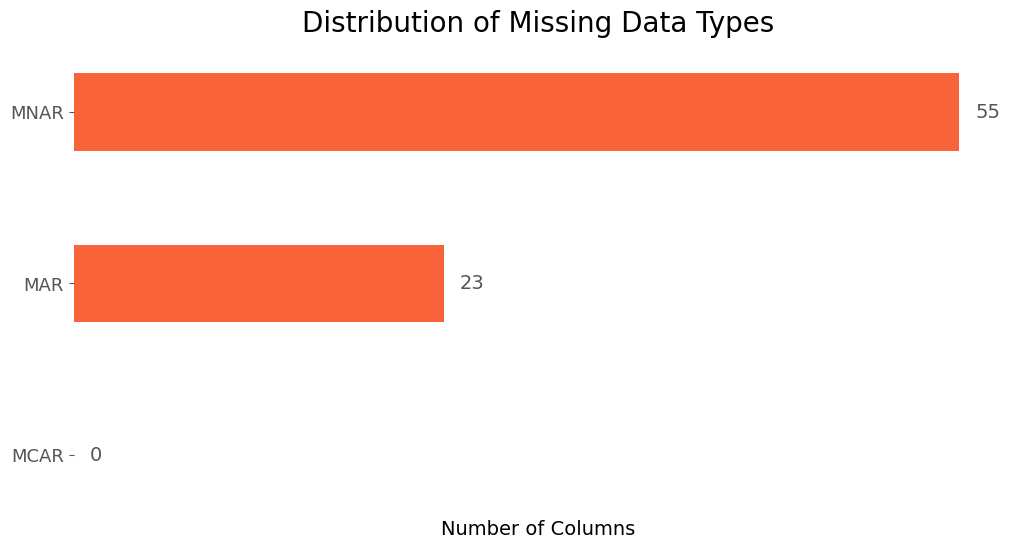

In [169]:
import matplotlib.pyplot as plt

labels = ['MCAR', 'MAR', 'MNAR']
values = [0, 23, 55]

colors = ['#D4D4D4', '#F9582CEF', '#F9582CEF']

plt.figure(figsize=(12, 6))
ax = plt.gca()

bars = ax.barh(labels, values, color=colors, height=0.45)

for i, v in enumerate(values):
    ax.text(v + 1, i, str(v), va='center', fontsize=14, color='#555555')

ax.set_title("Distribution of Missing Data Types", fontsize=20, pad=15)
ax.set_xlabel("Number of Columns", fontsize=14)

# ❌ Ẩn ticks + số trên trục X (giữ lại label trục)
ax.xaxis.set_ticks([])
ax.tick_params(axis='x', length=0)

# Ẩn grid + viền
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

ax.tick_params(axis='y', colors='#555555', labelsize=13)

plt.show()
